<a href="https://colab.research.google.com/github/TahaMsv/Bachelor-Project/blob/main/bachelor_project(SincNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# base_path = "/drive/Shared with me/Bachelor's project/UC San Diego/"
base_path = "/content/drive/MyDrive/Bachelor's project/UC San Diego/"

#Load data


In [ ]:
import mne
patient_raw = mne.io.read_raw_bdf(base_path + "pd/Copy of sub-pd3_ses-off_task-rest_eeg.bdf", preload=True)
patient_raw.plot(
    scalings='auto',
    show=True
)


In [ ]:
normal_raw = mne.io.read_raw_bdf(base_path + "hc/Copy of sub-hc1_ses-hc_task-rest_eeg.bdf", preload=True)
normal_raw.plot(
    scalings='auto',
    show=True
)

In [ ]:
num_channels = normal_raw.info['nchan']
sampling_rate = normal_raw.info['sfreq']
channel_names = normal_raw.info['ch_names']
recording_duration = normal_raw.times[-1]

print("Number of Channels:", num_channels)
print("Sampling Rate:", sampling_rate)
print("Channel Names:", channel_names)
print("Recording Duration (seconds):", recording_duration)

Number of Channels: 41
Sampling Rate: 512.0
Channel Names: ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
Recording Duration (seconds): 191.998046875


In [ ]:
data =np.load(base_path + "pre processed data.npy")
labels = np.load(base_path + "pre processed labels.npy")

In [ ]:
print(data.shape)
print(labels.shape)

(2880, 41, 1024)
(2880,)


In [ ]:
# eeg_data_shape = data.shape
# # Reshape the data into a 2D array with shape (2880, 41 * 1024)
# data = data.reshape((eeg_data_shape[0],1, eeg_data_shape[1] * eeg_data_shape[2]))

#Standard CNN

In [ ]:
import torch.nn as nn
class PDCNN(nn.Module):
    def __init__(self):
        super(PDCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=41, out_channels=5, kernel_size=20, stride=1)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=10, stride=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=10, stride=1)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=10, out_channels=15, kernel_size=5, stride=1)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=855, out_features=20)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(in_features=20, out_features=10)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(in_features=10, out_features=2)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.maxpool1(torch.relu(self.conv1(x)))
        x = self.maxpool2(torch.relu(self.conv2(x)))
        x = self.maxpool3(torch.relu(self.conv3(x)))
        x = self.maxpool4(torch.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = self.dropout3(self.fc3(x))

        return x


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the evaluation metrics
def calculate_metrics(conf_matrix):
    true_positive = conf_matrix[1, 1]
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    false_negative = conf_matrix[1, 0]

    accuracy = (true_positive + true_negative) / np.sum(conf_matrix)
    specificity = true_negative / (true_negative + false_positive)
    sensitivity = true_positive / (true_positive + false_negative)

    return accuracy, specificity, sensitivity

# Initialize K-Fold cross-validator
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store metrics for each fold
cnn_accuracies = []
cnn_specificities = []
cnn_sensitivities = []
cnn_loss_history = [[0 for x in range(50)] for y in range(10)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(data, labels)):
    print(f"Fold {fold+1}/{num_folds}")

    # Create data and labels subsets for this fold
    train_data, test_data = data[train_idx], data[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    # Convert data and labels to PyTorch tensors
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    # Create DataLoader for training
    train_dataset = TensorDataset(train_data, train_labels)
    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create the model instance
    model = PDCNN()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Assuming it's a classification task
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        for batch_data, batch_labels in train_dataloader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            cnn_loss_history[fold].append(loss.item())
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_data = test_data.to(device)
        test_labels = test_labels.to(device)
        predictions = model(test_data)
        _, predicted_labels = torch.max(predictions, 1)
        conf_matrix = confusion_matrix(test_labels.cpu(), predicted_labels.cpu())
        accuracy, specificity, sensitivity = calculate_metrics(conf_matrix)
        cnn_accuracies.append(accuracy)
        cnn_specificities.append(specificity)
        cnn_sensitivities.append(sensitivity)

    print(f"Accuracy: {accuracy}, Specificity: {specificity}, Sensitivity: {sensitivity}\n")

# Calculate average metrics over all folds
avg_accuracy = np.mean(cnn_accuracies)
avg_specificity = np.mean(cnn_specificities)
avg_sensitivity = np.mean(cnn_sensitivities)

print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Specificity: {avg_specificity}")
print(f"Average Sensitivity: {avg_sensitivity}")


Fold 1/10
Epoch [1/50], Loss: 0.6906191110610962
Epoch [2/50], Loss: 0.7074005603790283
Epoch [3/50], Loss: 0.679111897945404
Epoch [4/50], Loss: 0.6800945997238159
Epoch [5/50], Loss: 0.6980800628662109
Epoch [6/50], Loss: 0.6749581694602966
Epoch [7/50], Loss: 0.6808867454528809
Epoch [8/50], Loss: 0.6927914023399353
Epoch [9/50], Loss: 0.6987313628196716
Epoch [10/50], Loss: 0.694846510887146
Epoch [11/50], Loss: 0.7095680832862854
Epoch [12/50], Loss: 0.6959211826324463
Epoch [13/50], Loss: 0.6954081058502197
Epoch [14/50], Loss: 0.6752502918243408
Epoch [15/50], Loss: 0.695770263671875
Epoch [16/50], Loss: 0.6922778487205505
Epoch [17/50], Loss: 0.6966409087181091
Epoch [18/50], Loss: 0.6972407102584839
Epoch [19/50], Loss: 0.6843163371086121
Epoch [20/50], Loss: 0.6840235590934753
Epoch [21/50], Loss: 0.6713835000991821
Epoch [22/50], Loss: 0.6520752310752869
Epoch [23/50], Loss: 0.6389642953872681
Epoch [24/50], Loss: 0.6253034472465515
Epoch [25/50], Loss: 0.6097025275230408
Ep

In [ ]:
#LSTM results
cnn_results = {
        'accuracies': cnn_accuracies,
        'sensitivities': cnn_sensitivities,
        'specificities': cnn_specificities
    }

np.save(base_path + "cnn_results.npy", cnn_results)

In [ ]:
np.save(base_path + "cnn_loss.npy", cnn_loss_history)

#SincNet Implementation


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SincConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, sample_rate):
        super(SincConv, self).__init__()

        self.kernel_size = kernel_size
        self.sample_rate = sample_rate
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Define the bandpass parameters as learnable parameters
        self.center_frequencies = nn.Parameter(torch.rand(out_channels) * (sample_rate / 2))

        # Initialize the other required parameters
        self.window = nn.Parameter(torch.hann_window(kernel_size))
        self.bands = nn.Parameter(torch.exp(torch.linspace(torch.log(torch.tensor(20.0)), torch.log(torch.tensor(sample_rate / 2.0)), out_channels)))


    def forward(self, x):
        # Create sinc filters based on the learnable parameters
        filters = (2 * self.center_frequencies.view(-1, 1) * self.bands.view(1, -1) * torch.sinc(
            2 * self.center_frequencies.view(-1, 1) * (torch.arange(self.kernel_size).float() - (self.kernel_size - 1) / 2)
        )).to(x.device)

        # Apply the filters using convolution
        x = x.unsqueeze(1)  # Add a channel dimension
        x = x.view(x.size(0), x.size(1), -1)
        x = F.conv1d(x, filters.unsqueeze(1))
        return x


In [ ]:
class PDSincNet(nn.Module):
    def __init__(self):
        super(PDSincNet, self).__init__()

        self.sincconv1 = SincConv(in_channels=41, out_channels=5, kernel_size=5, sample_rate=512.0)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=10, stride=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=10, stride=1)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=10, out_channels=15, kernel_size=5, stride=1)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=39270, out_features=20)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(in_features=20, out_features=10)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(in_features=10, out_features=2)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.maxpool1(torch.relu(self.sincconv1(x)))
        x = self.maxpool2(torch.relu(self.conv2(x)))
        x = self.maxpool3(torch.relu(self.conv3(x)))
        x = self.maxpool4(torch.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = self.dropout3(self.fc3(x))

        return x


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the evaluation metrics
def calculate_metrics(conf_matrix):
    true_positive = conf_matrix[1, 1]
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    false_negative = conf_matrix[1, 0]

    accuracy = (true_positive + true_negative) / np.sum(conf_matrix)
    specificity = true_negative / (true_negative + false_positive)
    sensitivity = true_positive / (true_positive + false_negative)

    return accuracy, specificity, sensitivity

# Initialize K-Fold cross-validator
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store metrics for each fold
sincnet_accuracies = []
sincnet_specificities = []
sincnet_sensitivities = []
sincnet_loss_history = [[0 for x in range(50)] for y in range(10)]


for fold, (train_idx, test_idx) in enumerate(kfold.split(data, labels)):
    print(f"Fold {fold+1}/{num_folds}")

    # Create data and labels subsets for this fold
    train_data, test_data = data[train_idx], data[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    # Convert data and labels to PyTorch tensors
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    # Create DataLoader for training
    train_dataset = TensorDataset(train_data, train_labels)
    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create the model instance
    model = PDSincNet()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Assuming it's a classification task
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        for batch_data, batch_labels in train_dataloader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            sincnet_loss_history[fold].append(loss.item())
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_data = test_data.to(device)
        test_labels = test_labels.to(device)
        predictions = model(test_data)
        _, predicted_labels = torch.max(predictions, 1)
        conf_matrix = confusion_matrix(test_labels.cpu(), predicted_labels.cpu())
        accuracy, specificity, sensitivity = calculate_metrics(conf_matrix)
        sincnet_accuracies.append(accuracy)
        sincnet_specificities.append(specificity)
        sincnet_sensitivities.append(sensitivity)

    print(f"Accuracy: {accuracy}, Specificity: {specificity}, Sensitivity: {sensitivity}\n")

# Calculate average metrics over all folds
avg_accuracy = np.mean(sincnet_accuracies)
avg_specificity = np.mean(sincnet_specificities)
avg_sensitivity = np.mean(sincnet_sensitivities)

print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Specificity: {avg_specificity}")
print(f"Average Sensitivity: {avg_sensitivity}")


Fold 1/10
Epoch [1/50], Loss: 0.6529732942581177
Epoch [2/50], Loss: 0.6580419540405273
Epoch [3/50], Loss: 0.6455066800117493
Epoch [4/50], Loss: 0.5523369312286377
Epoch [5/50], Loss: 0.712159276008606
Epoch [6/50], Loss: 0.5658066868782043
Epoch [7/50], Loss: 0.5250038504600525
Epoch [8/50], Loss: 0.560652494430542
Epoch [9/50], Loss: 1.899572491645813
Epoch [10/50], Loss: 1.3737211227416992
Epoch [11/50], Loss: 0.49885597825050354
Epoch [12/50], Loss: 0.40681102871894836
Epoch [13/50], Loss: 0.5168861150741577
Epoch [14/50], Loss: 0.49427586793899536
Epoch [15/50], Loss: 0.40390461683273315
Epoch [16/50], Loss: 0.5146915316581726
Epoch [17/50], Loss: 0.4515836536884308
Epoch [18/50], Loss: 0.48524177074432373
Epoch [19/50], Loss: 0.48692458868026733
Epoch [20/50], Loss: 0.3816578686237335
Epoch [21/50], Loss: 0.40912961959838867
Epoch [22/50], Loss: 0.3882577121257782
Epoch [23/50], Loss: 0.4451031982898712
Epoch [24/50], Loss: 0.39054983854293823
Epoch [25/50], Loss: 0.42315381765

In [ ]:
sincnet_results = {
        'accuracies': sincnet_accuracies,
        'sensitivities': sincnet_sensitivities,
        'specificities': sincnet_specificities
    }

np.save(base_path + "sincnet_results.npy", sincnet_results)

In [ ]:
np.save(base_path + "sincnet_loss.npy", sincnet_loss_history)

#Conclusion

In [ ]:
loss_history2 = np.load(base_path + "sincnet_loss.npy")
loss_history1 = np.load(base_path + "cnn_loss.npy")
len(loss_history2[0])

4100

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of epoch numbers (assuming epoch numbers start from 1)
epochs = np.arange(1, 51)

# Create the line plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.plot(epochs, loss_history1, label='Model 1', marker='o', linestyle='-')
plt.plot(epochs, loss_history2, label='Model 2', marker='x', linestyle='-')

# Customize the plot
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
loaded_sincnet_results = np.load(base_path + "sincnet_results.npy", allow_pickle=True).item()
loaded_cnn_results = np.load(base_path + "cnn_results.npy", allow_pickle=True).item()
loaded_lstm_results = np.load(base_path + "lstm_results.npy", allow_pickle=True).item()
loaded_svm_results = np.load(base_path + "svm_results.npy", allow_pickle=True).item()

sincnet_accuracies = loaded_sincnet_results['accuracies']
sincnet_sensitivities = loaded_sincnet_results['sensitivities']
sincnet_specificities = loaded_sincnet_results['specificities']

cnn_accuracies = loaded_cnn_results['accuracies']
cnn_sensitivities = loaded_cnn_results['sensitivities']
cnn_specificities = loaded_cnn_results['specificities']

lstm_accuracies = loaded_lstm_results['accuracies']
lstm_sensitivities = loaded_lstm_results['sensitivities']
lstm_specificities = loaded_lstm_results['specificities']

svm_accuracies = loaded_svm_results['accuracies']
svm_sensitivities = loaded_svm_results['sensitivities']
svm_specificities = loaded_svm_results['specificities']

In [ ]:
import matplotlib.pyplot as plt

def show_plot(ylabel , title, sincnet_result, cnn_result, lstm_result, svm_result):

  fold_numbers = range(1,11)
  bar_width = 0.15
  fig, ax = plt.subplots(figsize=(10, 6))
  x = np.arange(len(fold_numbers))

  ax.bar(x - 3 * bar_width / 2 , sincnet_result, width=bar_width , label='SincNet', align='center')
  ax.bar(x - bar_width / 2 , cnn_result, width=bar_width, label='CNN', align='center')
  ax.bar(x  + bar_width / 2, lstm_result, width=bar_width, label='LSTM', align='center')
  ax.bar(x + 3 * bar_width  / 2, svm_result, width=bar_width, label='SVM', align='center')

  # Customize the plot
  ax.set_xlabel('Fold Number')
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.set_xticks(x)
  ax.set_xticklabels(fold_numbers)
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=5)

  # Show the plot
  plt.grid(True)
  plt.tight_layout()
  plt.show()


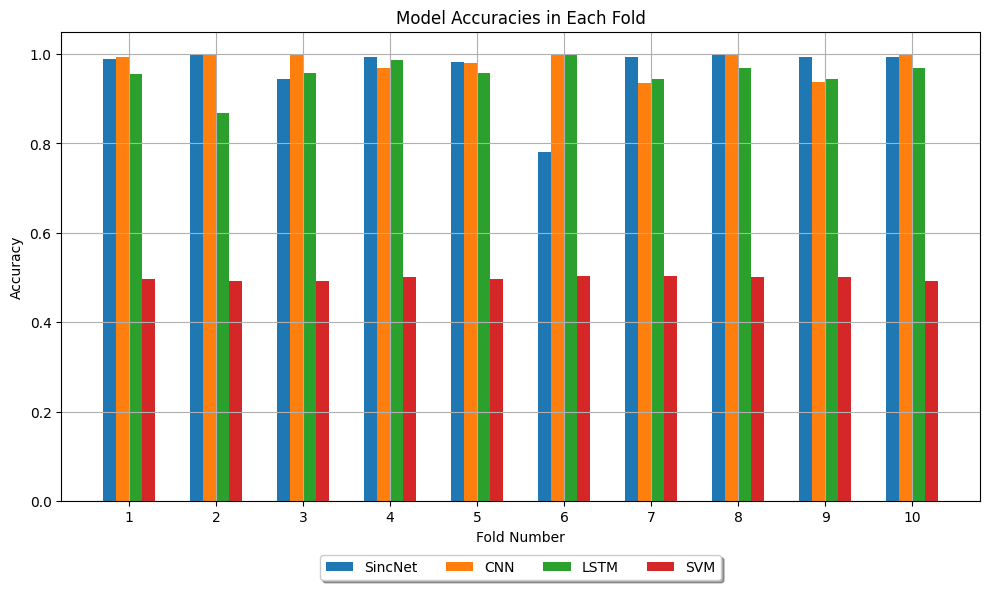

In [ ]:
show_plot("Accuracy" , 'Model Accuracies in Each Fold' , sincnet_accuracies, cnn_accuracies, lstm_accuracies, svm_accuracies)

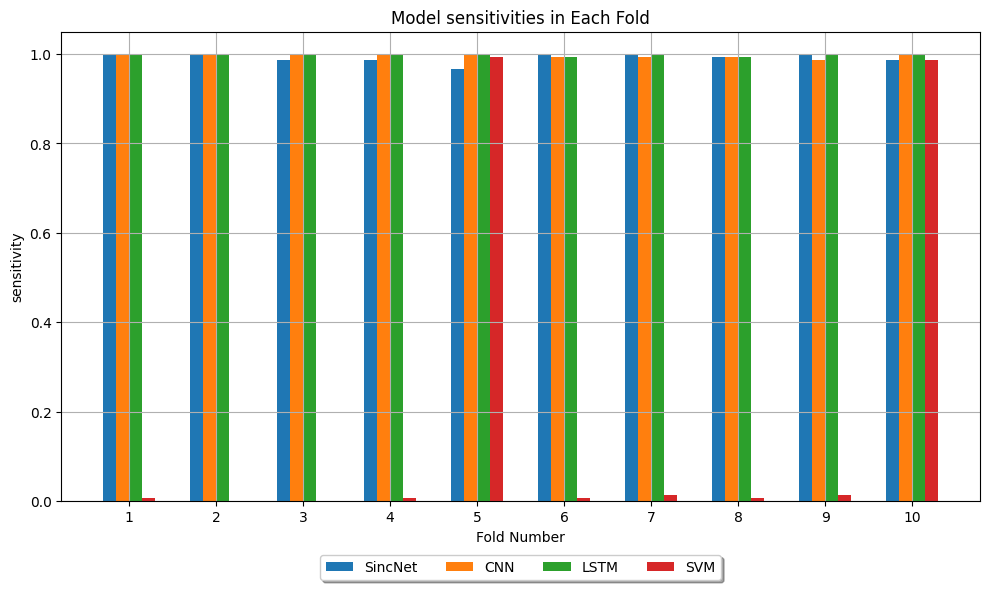

In [ ]:
show_plot("Sensitivity" , 'Model sensitivities in Each Fold' , sincnet_sensitivities, cnn_sensitivities, lstm_sensitivities, svm_sensitivities)

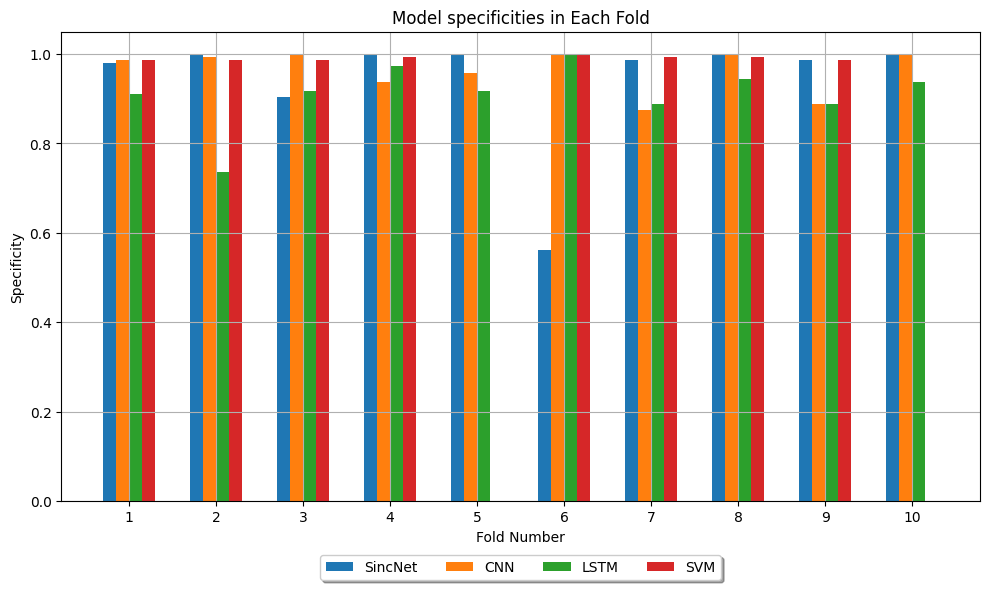

In [ ]:
show_plot("Specificity" , 'Model specificities in Each Fold' , sincnet_specificities, cnn_specificities, lstm_specificities, svm_specificities)

#SincNet Implementation 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SincConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, sample_rate):
        super(SincConv, self).__init__()

        self.sample_rate = sample_rate
        self.min_freq = 50.0
        self.min_band = 50.0
        self.kernel_size = kernel_size
        self.param = nn.Parameter(torch.Tensor(out_channels, in_channels, 1))

        # Initialize the weights
        self.param.data.uniform_(-0.01, 0.01)

    def forward(self, x):
        filters = self.param

        # Compute bandpass filters
        low = self.min_freq / self.sample_rate
        high = (self.min_freq + 2.0 * self.min_band) / self.sample_rate
        t_right = (torch.arange(1, self.kernel_size + 1, dtype=torch.float32) - (self.kernel_size + 1) / 2.0) / self.sample_rate
        bandpass = 2.0 * high * torch.sinc(2.0 * high * t_right) - 2.0 * low * torch.sinc(2.0 * low * t_right)

        filters = filters * bandpass.view(1, 1, -1)

        # Apply the filters
        x = F.conv1d(x, filters)

        return x


In [ ]:
class PDCNNWithSinc(nn.Module):
    def __init__(self, sample_rate):
        super(PDCNNWithSinc, self).__init__()

        # SincNet layer
        self.sinc_conv = SincConv(in_channels=1, out_channels=41, kernel_size=101, sample_rate=sample_rate)

        self.conv1 = nn.Conv1d(in_channels=41, out_channels=5, kernel_size=20, stride=1)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=10, stride=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=10, stride=1)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=10, out_channels=15, kernel_size=5, stride=1)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=19530, out_features=20)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(in_features=20, out_features=10)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(in_features=10, out_features=2)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        # Apply SincNet layer
        x =self.maxpool1(torch.relu(self.sinc_conv(x)))

        x = self.maxpool1(torch.relu(self.conv1(x)))
        x = self.maxpool2(torch.relu(self.conv2(x)))
        x = self.maxpool3(torch.relu(self.conv3(x)))
        x = self.maxpool4(torch.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = self.dropout3(self.fc3(x))

        return x


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the evaluation metrics
def calculate_metrics(conf_matrix):
    true_positive = conf_matrix[1, 1]
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    false_negative = conf_matrix[1, 0]

    accuracy = (true_positive + true_negative) / np.sum(conf_matrix)
    specificity = true_negative / (true_negative + false_positive)
    sensitivity = true_positive / (true_positive + false_negative)

    return accuracy, specificity, sensitivity

# Initialize K-Fold cross-validator
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracies = []
specificities = []
sensitivities = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(data, labels)):
    print(f"Fold {fold+1}/{num_folds}")

    # Create data and labels subsets for this fold
    train_data, test_data = data[train_idx], data[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    # Convert data and labels to PyTorch tensors
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    # Create DataLoader for training
    train_dataset = TensorDataset(train_data, train_labels)
    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create the model instance (PDCNN)
    model = PDCNNWithSinc(sample_rate=512.0)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Assuming it's a classification task
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        for batch_data, batch_labels in train_dataloader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_data = test_data.to(device)
        test_labels = test_labels.to(device)
        predictions = model(test_data)
        _, predicted_labels = torch.max(predictions, 1)
        conf_matrix = confusion_matrix(test_labels.cpu(), predicted_labels.cpu())
        accuracy, specificity, sensitivity = calculate_metrics(conf_matrix)
        accuracies.append(accuracy)
        specificities.append(specificity)
        sensitivities.append(sensitivity)

    print(f"Accuracy: {accuracy}, Specificity: {specificity}, Sensitivity: {sensitivity}\n")

# Calculate average metrics over all folds
avg_accuracy = np.mean(accuracies)
avg_specificity = np.mean(specificities)
avg_sensitivity = np.mean(sensitivities)

print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Specificity: {avg_specificity}")
print(f"Average Sensitivity: {avg_sensitivity}")


Fold 1/10
